In [ ]:
%pip install wordcloud matplotlib nltk


Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 7.2 MB/s eta 0:00:00
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("WordCloud").getOrCreate()

# Load the data
df = spark.read.option("header", "true").csv("dbfs:/FileStore/tables/tweets.csv")

df.show()




+--------------------+
|              Tweets|
+--------------------+
|I think there’s a...|
|“You know Harry P...|
|       “Not really.”|
|       “The movies?”|
|               “No.”|
| “I’m a Hufflepuff.”|
|         “Congrats?”|
|GET OUT OF THERE ...|
|Sell all your hou...|
|Starship Troopers...|
|liberal viewers t...|
|conservatives thi...|
|What other movies...|
|Then this & they ...|
|Best Gary Oldman ...|
|Find out how an u...|
|"fauni just calle...|
|Jamie Dornan and ...|
|Just saw that a R...|
|My brother, Benja...|
+--------------------+
only showing top 20 rows



In [ ]:
df.count()

27125

In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType
import string
import re

# Define a UDF to remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

remove_punctuation_udf = udf(remove_punctuation, StringType())

def clean_text(text):
    if text is None:
        return ""
    text = str(text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\b\w{1}\b', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

clean_text_udf = udf(clean_text, StringType())

# Clean and remove punctuation
df = df.withColumn("cleaned_text", clean_text_udf(df["Tweets"]))
df = df.withColumn("clean_text", remove_punctuation_udf(df["cleaned_text"]))

# Ensure the column does not exist before creating it
if not 'words_temp' in df.columns:
    tokenizer = Tokenizer(inputCol="clean_text", outputCol="words_temp")
    df = tokenizer.transform(df)

# Ensure the column does not exist before creating it
if not 'filtered_words' in df.columns:
    remover = StopWordsRemover(inputCol="words_temp", outputCol="filtered_words")
    df = remover.transform(df)

df.select("filtered_words").show()


+--------------------+
|      filtered_words|
+--------------------+
|[think, there’s, ...|
|[“you, know, harr...|
|     [“not, really”]|
|     [“the, movies”]|
|              [“no”]|
| [“i’m, hufflepuff”]|
|        [“congrats”]|
|[get, sweet, huff...|
|[sell, houses, st...|
|[starship, troope...|
|[liberal, viewers...|
|[conservatives, t...|
|[movies, politica...|
|[, never, ran, fe...|
|[best, gary, oldm...|
|[find, unexpected...|
|[fauni, called, j...|
|[jamie, dornan, m...|
|[saw, russiansout...|
|[brother, benjami...|
+--------------------+
only showing top 20 rows



In [ ]:
# Check for nulls in the DataFrame
if df.filter(df["clean_text"].isNull()).count() > 0:
    print("Null values found in 'clean_text' column")
    df = df.na.fill({'clean_text': ''})  # Replace nulls with an empty string


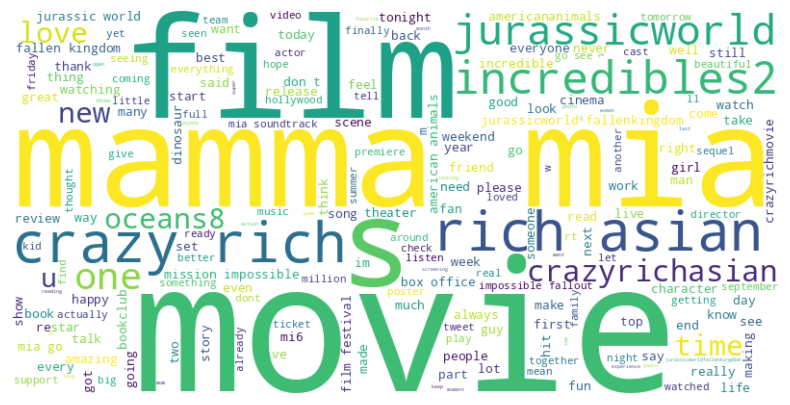

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Collect words into a list
words = df.select("filtered_words").rdd.flatMap(lambda x: x).collect()

# Flatten the list of words
flat_list = [item for sublist in words for item in sublist]

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(" ".join(flat_list))

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
